# Typical use case for physical parameters

This example notebook shows a run on the COSMOS2020 (Weaver et al. 2022) data set in order to estimate the physical parameters.

In this notebook we follow what has been done for photo-z. We will be looking at the same COSMOS data set but only use the ugrizy bands. The main difference is the use of BC03 templates to compute physical parameters, and we set the redshift to its spectrosocpic value.

In [12]:
import lephare as lp
from astropy.table import Table
import numpy as np
import os
from matplotlib import pylab as plt
import time

%matplotlib inline

## Update the config
We will start with the COSMOS configuration as a basis. We will update the various keywords needed for this example. We use the default which is shipped with lephare. You could also download the example text file config from [here](https://github.com/lephare-photoz/lephare-data/blob/main/examples/COSMOS.para) or write it completely from scratch.

In [13]:
config = lp.default_cosmos_config.copy()

# You could also load this from a local text file:
# !curl -s -o https://raw.githubusercontent.com/lephare-photoz/lephare-data/refs/heads/main/examples/COSMOS.para
# config = lp.read_config("./COSMOS.para")

config.update(
    {
        # For a quick demonstration we use a very sparse redshift grid. DO NOT USE FOR SCIENCE!
        # Comment out the following line to improve results.
        "Z_STEP": "0.1,0.,3.",
        # SED
        # In order to get the physical parameters you need to use 
        # Composite Stellar Population synthesis models. Here Bruzual & Charlot (2003). 
        # This can be done only for galaxies. 
        "GAL_SED" : "$LEPHAREDIR/sed/GAL/BC03_CHAB/BC03COMB_MOD.list",
        # Limit the number of ages
        "SEL_AGE" : "$LEPHAREDIR/sed/GAL/BC03_CHAB/AGE_BC03COMB.dat",
        "MOD_EXTINC" : "0,12,0,12",
        "EXTINC_LAW" : "SB_calzetti.dat,SMC_prevot.dat",
        "EM_LINES" : "PHYS",
        "EM_DISPERSION" : "1.",
        # FILTERS
        # A reduced list of filters:
        "FILTER_LIST": "cosmos/u_new.pb,hsc/gHSC.pb,hsc/rHSC.pb,hsc/iHSC.pb,hsc/zHSC.pb,hsc/yHSC.pb",
        "FILTER_CALIB": "0",
        "FILTER_FILE": "filter_test",
        # FIT
        # We set the redshift to the spec-z value
        "ZFIX":"YES",
        "ERR_SCALE": "0.02",
        "ERR_FACTOR": "1.5",
        "SPEC_OUT": "NO",  # We would like to see the output
    }
)

## Download the missing data
One does not need to use this functionality if already cloned the full auxiliary data.



In [14]:
lp.data_retrieval.get_auxiliary_data(
    keymap=config,
    # The additional extinction laws for galaxies are not in the principle config
    # so we must add them to be downloaded:
    additional_files=[
        # We also want the example cosmos catalogue to experiment with
        "examples/COSMOS.in",
        "ext/SMC_prevot.dat",
        "ext/SB_calzetti.dat",
    ],
)

Registry file downloaded and saved as data_registry.txt.


Updating file 'alloutputkeys.txt' from 'https://raw.githubusercontent.com/lephare-photoz/lephare-data/main/alloutputkeys.txt' to '/data1/LEPHARE_GITHUB/lephare-data'.


Checking/downloading 384 files...
384 completed.
All files downloaded successfully and are non-empty.
Checking/downloading 3 files...
3 completed.
All files downloaded successfully and are non-empty.


## Run prepare

These are the key preparatory stages that calculate the filters in the LePHARE format, calculate the library of SEDs and finally calculate the library of magnitudes for all the models. The prepare method runs *filter*, *sedtolib*, and *mag_gal* that would be run independently at the command line. These are all explained in detail in the [documentation](https://lephare.readthedocs.io/en/latest/original.html#detailed-lephare-user-manual).

In [4]:
lp.prepare(
    config,
)

# NAME                        IDENT      Lbda_mean Lbeff(Vega)       FWHM     AB-cor    TG-cor      VEGA M_sun(AB)   CALIB      Lb_eff    Fac_corr
u_new.pb                      1             0.3690      0.3750      0.0456    0.6195   -0.2745  -20.8527    6.3135       0      0.3668      1.0000
gHSC.pb                       2             0.4851      0.4760      0.1194   -0.0860   -0.2458  -20.7272    5.0764       0      0.4780      1.0000
rHSC.pb                       3             0.6241      0.6142      0.1539    0.1466    0.2580  -21.5143    4.6523       0      0.6178      1.0000
iHSC.pb                       4             0.7716      0.7637      0.1476    0.3942    0.6138  -22.2286    4.5323       0      0.7666      1.0000
zHSC.pb                       5             0.8915      0.8907      0.0768    0.5169    0.7625  -22.6733    4.5147       0      0.8903      1.0000
yHSC.pb                       6             0.9801      0.9771      0.0797    0.5534    0.7763  -22.9145    4.5081    

### Creating the input table

We need to make an astropy table as input. This can be done using the standard column order:
id, flux0, err0, flux1, err1,..., context, zspec, arbitrary_string. A simple example table with two filters might look like this:
|  id | flux_filt1  |  fluxerr_filt1 |  flux_filt2  |  fluxerr_filt2 | context | zspec | string_data |
|---|---|---|---|---|---|---|---|
|  0 | 1.e-31  | 1.e-32  | 1.e-31  | 2.e-32  | 3 | NaN | "This is just a note" |
|  1 | 2.e-31  |  1.e-32 | 1.e-31  | 2.e-32  |3 | 1. | "This has a specz" |
|  2 | 2.e-31 | 1.e-32  | 2.e-31  | 2.e-32  | 2 | NaN| "This context only uses the second filter" |

The context detemermines which bands are used but can be -99 or a numpy.nan. We do not need to have units on the flux columns but LePHARE assumes they are in erg /s /cm**2 / Hz if we are using fluxes. The number of columns must be two times the number of filters plus the four additional columns.

This input table **must use** the standard column ordering to determine column meaning. This odering depends on the filter order in the config FILTER_LIST value. 

In [5]:
# Load the full cosmos example we downloaded at the start
cosmos_full = Table.read(f"{lp.LEPHAREDIR}/examples/COSMOS.in", format="ascii")
# Lets just look at the first 1000 specz between 0 and 3 to be fast and have a small sample to test
specz_colname = cosmos_full.colnames[-2]
mask = cosmos_full[specz_colname] > 0
mask &= cosmos_full[specz_colname] < 3
cosmos_full = cosmos_full[mask][:1000]

In [6]:
input_table = Table()
# The id is in the first column
input_table["id"] = cosmos_full[cosmos_full.colnames[0]]
# Loop over the filters we want to keep to get the number of the filter, n, and the name, b,
filter_names = config["FILTER_LIST"].split(",")
for n, filter_name in enumerate(filter_names):
    # The ugrizy fluxes and errors are in cols 3 to 14
    f_col = cosmos_full.colnames[2 * n + 3]
    ferr_col = cosmos_full.colnames[2 * n + 4]
    # By default lephare uses column order so names are irrelevant
    input_table[f"f_{filter_name}"] = cosmos_full[f_col]
    input_table[f"ferr_{filter_name}"] = cosmos_full[ferr_col]
# The context is a binary flag. Here we set it to use all filters.
input_table["context"] = np.sum(2 ** np.arange(len(filter_names)))
input_table["zspec"] = cosmos_full[specz_colname]
input_table["string_data"] = "arbitrary_info"

In [7]:
# Look at the first 5 lines of the input table
input_table[:5]

id,f_cosmos/u_new.pb,ferr_cosmos/u_new.pb,f_hsc/gHSC.pb,ferr_hsc/gHSC.pb,f_hsc/rHSC.pb,ferr_hsc/rHSC.pb,f_hsc/iHSC.pb,ferr_hsc/iHSC.pb,f_hsc/zHSC.pb,ferr_hsc/zHSC.pb,f_hsc/yHSC.pb,ferr_hsc/yHSC.pb,context,zspec,string_data
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str14
2,4.232901366689564e-30,3.4341315142888603e-31,6.179738935719169e-30,1.386731273412228e-31,1.2142639224559102e-29,1.8245325069819158e-31,2.1114793014441938e-29,2.1601688228846318e-31,3.9365460376947166e-29,3.4133974396324463e-31,5.0357913173859444e-29,5.203234525553232e-31,63,1.166,arbitrary_info
3,1.8604787800453155e-28,3.6102558328725637e-31,1.0163707206619843e-27,2.5508479438832455e-30,2.5637553789165174e-27,3.907537695918684e-30,3.852181904261173e-27,4.270412613938428e-30,5.051842896248005e-27,5.651717781917373e-30,5.820737300549565e-27,6.786202238144557e-30,63,0.1649,arbitrary_info
6,3.883122772291653e-30,9.595010842153324e-32,4.647041003941889e-30,1.087246463423006e-31,4.8469179256155955e-30,1.178374194432367e-31,6.118486088007425e-30,1.2683990766417867e-31,9.150015677196151e-30,1.9130763838587345e-31,1.0166486142973662e-29,3.495575779500692e-31,63,1.25,arbitrary_info
9,2.8521064572984233e-30,1.897459353660885e-31,7.283799341197919e-30,1.7286878697910101e-31,2.3956967578910942e-29,2.8232988053219177e-31,5.597814087271151e-29,3.7781712042067346e-31,8.467793964385691e-29,5.472733062400153e-31,1.0885331971552352e-28,7.893832949105172e-31,63,0.6233,arbitrary_info
10,4.0113693940454606e-30,1.4061914648406559e-31,5.3481882134164066e-30,1.4193075132576959e-31,6.221652738450281e-30,1.5878330837093787e-31,7.330388037942477e-30,1.735529599561101e-31,1.1108868491203026e-29,2.6930229981999465e-31,1.5213763225065445e-29,5.031524893553477e-31,63,1.4005,arbitrary_info


## Run process

Finally we run the main fitting process which is equivalent to *zphota* when using the command line. We also need to update some of the config values to make them consistent with the number of filters.

In [8]:
# Compute physical parameters
output, _ = lp.process(config, input_table)

Using user columns from input table assuming they are in the standard order.
Processing 1000 objects with 6 bands
####################################### 
# PHOTOMETRIC REDSHIFT with OPTIONS   # 
# Config file            : 
# CAT_IN                 : change_me_to_output_filename_required.ascii
# CAT_OUT                : zphot.out
# CAT_LINES              : 0 1000000000
# PARA_OUT               : /data1/LEPHARE_GITHUB/lephare-data//examples/output.para
# INP_TYPE               : F
# CAT_FMT[0:MEME 1:MMEE] : 0
# CAT_MAG                : AB
# ZPHOTLIB               : CE_COSMOS STAR_COSMOS QSO_COSMOS 
# FIR_LIB                : 
# FIR_LMIN               : 7.000000
# FIR_CONT               : -1.000000
# FIR_SCALE              : -1.000000
# FIR_FREESCALE          : YES
# FIR_SUBSTELLAR         : NO
# ERR_SCALE              : 0.020000 
# ERR_FACTOR             : 1.500000 
# GLB_CONTEXT            : 0
# FORB_CONTEXT           : -1
# DZ_WIN                 : 1.000000
# MIN_THRES              : 

/data1/LEPHARE_GITHUB/lephare/src/lephare/_photoz.py:34: UserWarning: Input line 35 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  d = np.loadtxt(os.path.join(os.environ["LEPHAREDIR"], "alloutputkeys.txt"), dtype="str")


In [9]:
# the output is an astropy tabel that can be manipulated in the standard ways.
output[:5]

IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_MED,Z_MED68_LOW,Z_MED68_HIGH,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,Z_SEC,CHI_SEC,MOD_SEC,EBV_SEC,ZQ_BEST,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,MAG_OBS(),ERR_MAG_OBS(),K_COR(),MAG_ABS(),EMAG_ABS(),MABS_FILT(),SCALE_BEST,NBAND_USED,CONTEXT,ZSPEC,AGE_BEST,AGE_INF,AGE_MED,AGE_SUP,LDUST_BEST,LDUST_INF,LDUST_MED,LDUST_SUP,LUM_TIR_BEST,LUM_TIR_INF,LUM_TIR_MED,LUM_TIR_SUP,MASS_BEST,MASS_INF,MASS_MED,MASS_SUP,SFR_BEST,SFR_INF,SFR_MED,SFR_SUP,SSFR_BEST,SSFR_INF,SSFR_MED,SSFR_SUP,COL1_INF,COL1_MED,COL1_SUP,COL2_INF,COL2_MED,COL2_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,MAG_PRED(),STRING_INPUT,BAY_ZG
str3,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[0],str1,float64[31]
0,1.166,0.0,3.0,1.2000000000000002,1.1319999992847445,1.2680000007152559,7.353547030322183,7,2.0,0.3,-99.9,-99.0,-99,-99.0,1.166,6.672257421014208,7,-99,1000000000.0,24.83340462789454 .. 22.14483068826189,0.1355221450661712 .. 0.03439919376856379,1.4027514359493192 .. 0.22746431903521272,-20.76039123476376 .. -22.595422660630916,0.35799910340307406 .. 3.217256181124121,3.0 .. 5.0,508394575538.1546,6,0,1.166,9.477121254719663,9.070826931809764,9.340808033918837,9.585138349049188,11.262688906793807,11.263775914659584,11.31921324390277,11.430530743344463,-999.0,-99.9,-99.9,-99.9,10.458906909307618,10.305498041588109,10.460449856228049,10.617354682294922,1.1856501725118802,1.1460700391298684,1.254851965731712,1.4173108543425348,1.1856501725118802,-9.386450745969796,-9.182778986875206,-8.908110590004203,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,10.098781878596972,10.079056546113724,9.26246804596414,,,0.0 .. 0.0
1,0.1649,0.0,3.0,0.2,0.13199999928474426,0.26800000071525576,1.127109729785316,1,1.0,0.35,-99.9,-99.0,-99,-99.0,0.1649,62.80205816122945,3,-99,1000000000.0,20.725938197553823 .. 16.98755500174321,0.03016607985901451 .. 0.030060055672664364,0.8065954644069318 .. 0.11396514031072706,-19.553034052624728 .. -22.618055215012145,1.2252872539779265 .. 0.9043228285283575,1.0 .. 5.0,62291433485.13771,6,0,0.1649,8.85654824429995,8.814715058852782,8.882787049787268,9.002480837126864,10.946517075165014,11.108956976568155,11.162439684103527,11.238848432982804,-999.0,-99.9,-99.9,-99.9,10.597128578764885,10.739540782287092,10.781647330152634,10.82537362398034,-0.3268503478547725,-1.4055377938750317,-0.1761292779683207,-0.00037526675499195694,-0.3268503478547725,-12.205537469043191,-10.976131415901882,-10.800382201257246,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,9.42570394618821,10.187058622417833,9.425068101607351,,,0.0 .. 0.0
2,1.25,0.0,3.0,1.2000000000000002,1.1319999992847445,1.2680000007152559,0.8753132980664218,11,1.0,0.15,-99.9,-99.0,-99,-99.0,1.25,25.91018645939123,13,-99,1000000000.0,24.92704719548275 .. 23.882072817400996,0.05020167671229883 .. 0.06353871767418252,-0.16111586808040457 .. -0.21214526248971308,-19.57709975782467 .. -20.605487428788244,0.3375439166770793 .. 3.6044856532246143,4.0 .. 5.0,13803624804.673458,6,0,1.25,8.85654824429995,8.536017876504694,8.803608585052846,9.107455083407531,10.581529249478102,10.213565216857885,10.489423305486685,10.574905411891562,-999.0,-99.9,-99.9,-99.9,9.19186249267866,8.975560033754876,9.115778480543227,9.261780580497703,0.684413476414361,0.31552402209590663,0.5099874640159455,0.6591685767866572,0.684413476414361,-8.922962444876912,-8.563317879883106,-8.395134335338103,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,9.548654102471012,9.214921861147548,8.340639502400958,,,0.0 .. 0.0
3,0.6233,0.0,3.0,0.6000000000000001,0.5319999992847443,0.6680000007152558,10.085531

Next we can perform some simple plots to check the output

Text(0.5, 0, 'log(stellar mass)')

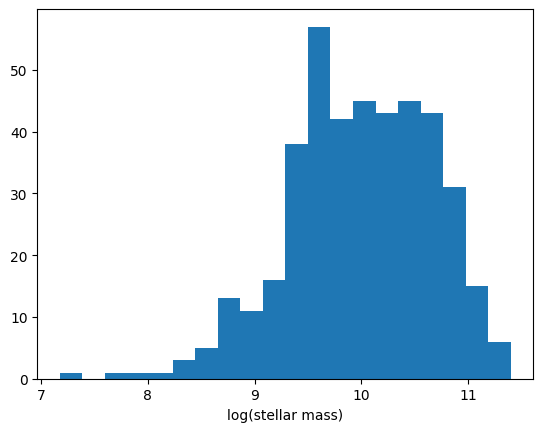

In [10]:
logmass= output["MASS_MED"]
logSFR= output["SFR_MED"]
z= output["Z_BEST"]
cond = (z>0.5) & (z<1) & (logmass>0)
plt.hist(logmass[cond], bins=20)
plt.xlabel("log(stellar mass)")

Text(0, 0.5, 'log(SFR)')

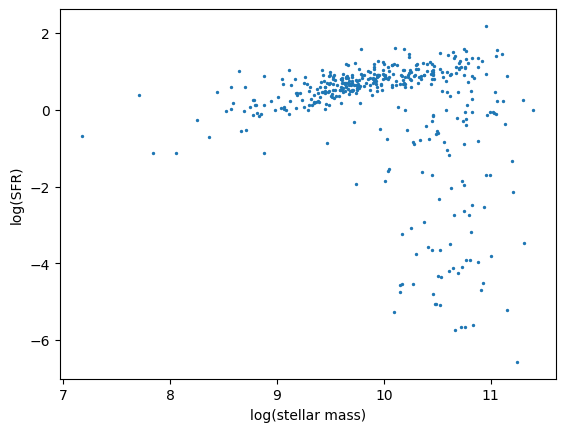

In [11]:
plt.scatter(logmass[cond], logSFR[cond], s=2.0)
plt.xlabel("log(stellar mass)")
plt.ylabel("log(SFR)")